## 1. Setup & Data Loading

# Construction Project Overrun Prediction - EDA & Feature Engineering

## Project Overview
**Goal:** Predict next-day TIME and COST overrun risk using lagged telemetry data from construction projects.

**Problem:** Construction projects frequently exceed time schedules (65% of days) and cost budgets (59% of days). Early warning can enable intervention.

**Approach:** 
1. Aggregate hourly data to daily (aligned with project management cycles)
2. Define binary targets: >7% deviation = overrun (industry-aligned threshold)
3. Engineer features: lag features (1,2,3,5,7 days) + derived efficiency KPIs
4. Apply **mixed strategy**: LAG-only for TIME, Derived+LAG for COST

## This Notebook
This notebook performs:
- Exploratory Data Analysis (EDA)
- Data aggregation (hourly → daily)
- Feature engineering (lags + derived KPIs)
- Target definition (7% threshold)
- Train/validation/test split (chronological, no leakage)
- Feature selection (top 10 per model)
- Data preparation for modeling

**Output:** `prepared_data/modeling_datasets.pkl` containing all datasets ready for model training.

---

In [94]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

In [95]:
df1 = pd.read_csv('../data/construction_project_dataset.csv')
df2 = pd.read_csv('../data/construction_project_performance_dataset.csv')

In [96]:
df1.head()

,timestamp,temperature,humidity,vibration_level,material_usage,machinery_status,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,safety_incidents,equipment_utilization_rate,material_shortage_alert,risk_score,simulation_deviation,update_frequency,optimization_suggestion,performance_score
0,2023-01-01 00:00:00,24.363503,70.834195,29.038952,162.290510,0,10,394.617852,0.025050,2707.711346,-4.645563,2,84.481661,0,23.181975,0.768037,10,Optimize Material Usage,Excellent
1,2023-01-01 00:01:00,38.767858,49.671023,26.348582,627.127074,1,16,334.086917,0.062199,1866.881543,-0.673013,0,85.115701,0,64.242931,6.958721,15,Optimize Material Usage,Excellent
2,2023-01-01 00:02:00,33.299849,31.727937,17.551847,818.981866,0,17,70.030254,0.141820,-2913.483082,-5.667880,0,82.006109,0,97.199452,8.980785,5,Reallocate Workers,Excellent
3,2023-01-01 00:03:00,29.966462,64.198507,24.660633,788.025785,1,19,275.610928,0.169591,-2778.924736,-8.373158,0,93.410108,1,58.238809,3.295682,5,Reallocate Workers,Excellent
4,2023-01-01 00:04:00,18.900466,45.120688,18.254832,853.656587,0,32,377.220779,0.185736,-2332.484349,-3.455996,0,52.694279,0,19.748945,0.223819,15,Optimize Material Usage,Excellent


In [97]:
df2.head()

,Timestamp,Sensor_ID,Temperature (°C),Humidity (%),Vibration_Level (Hz),Material_Usage (kg),Energy_Consumption (kWh),Worker_Count,Task_Progress (%),Safety_Incidents,Resource_Utilization (%),Risk_Score,Simulation_Accuracy (%),Optimization_Suggestion,Performance_Score
0,2023-01-01 00:00:00,Sensor_41,26.236204,42.418449,36.499916,674.330112,184.510419,18,0.086506,0,86.518381,32.607806,81.458493,Enhance Safety Measures,Exceptional
1,2023-01-01 00:01:00,Sensor_27,43.521429,39.974726,9.225600,513.363208,92.667999,79,0.162888,0,91.003107,98.116388,83.014287,Adjust Schedule,Exceptional
2,2023-01-01 00:02:00,Sensor_20,36.959818,30.569235,17.331985,968.048672,106.861651,33,0.241355,0,56.741970,85.460188,80.202505,Reallocate Workers,Exceptional
3,2023-01-01 00:03:00,Sensor_31,32.959755,56.436000,33.164032,297.080606,131.302008,99,0.267392,0,83.964498,14.811443,81.966505,Enhance Safety Measures,Exceptional
4,2023-01-01 00:04:00,Sensor_12,19.680559,48.597450,24.104467,629.070774,141.644000,74,0.321956,0,96.045832,20.387714,91.292507,Increase Machinery Efficiency,Exceptional


In [98]:
print(df1.shape)
print(df2.shape)

(50000, 19)
(10000, 15)


In [99]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   50000 non-null  datetime64[ns]
 1   temperature                 50000 non-null  float64       
 2   humidity                    50000 non-null  float64       
 3   vibration_level             50000 non-null  float64       
 4   material_usage              50000 non-null  float64       
 5   machinery_status            50000 non-null  int64         
 6   worker_count                50000 non-null  int64         
 7   energy_consumption          50000 non-null  float64       
 8   task_progress               50000 non-null  float64       
 9   cost_deviation              50000 non-null  float64       
 10  time_deviation              50000 non-null  float64       
 11  safety_incidents            50000 non-null  int64     

<Figure size 1400x600 with 0 Axes>

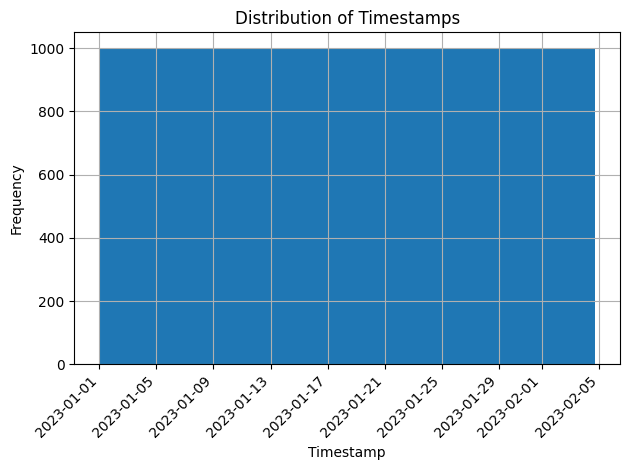

In [100]:
plt.figure(figsize=(14, 6))
df1.hist(column='timestamp', bins=50)
plt.xticks(rotation=45, ha='right')  # ha='right' aligns better
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.tight_layout()
plt.show()

In [101]:
# Check the actual time range and intervals
print("Date Range:")
print(f"Start: {df1['timestamp'].min()}")
print(f"End: {df1['timestamp'].max()}")
print(f"Duration: {df1['timestamp'].max() - df1['timestamp'].min()}")

# Check the time intervals between consecutive records
print("\nTime Intervals:")
time_diffs = df1['timestamp'].diff()
print(f"Most common interval: {time_diffs.mode()[0]}")
print(f"Mean interval: {time_diffs.mean()}")

Date Range:
Start: 2023-01-01 00:00:00
End: 2023-02-04 17:19:00
Duration: 34 days 17:19:00

Time Intervals:
Most common interval: 0 days 00:01:00
Mean interval: 0 days 00:01:00


In [102]:
# Look at how deviation changes throughout a single day
df1[df1['timestamp'].dt.date == pd.Timestamp('2023-01-01').date()][['timestamp', 'time_deviation', 'cost_deviation']].head(20)

,timestamp,time_deviation,cost_deviation
0,2023-01-01 00:00:00,-4.645563,2707.711346
1,2023-01-01 00:01:00,-0.673013,1866.881543
2,2023-01-01 00:02:00,-5.667880,-2913.483082
3,2023-01-01 00:03:00,-8.373158,-2778.924736
4,2023-01-01 00:04:00,-3.455996,-2332.484349
5,2023-01-01 00:05:00,9.123024,-2623.835150
6,2023-01-01 00:06:00,-3.059610,-4824.345237
7,2023-01-01 00:07:00,-5.256213,62.097874
8,2023-01-01 00:08:00,-6.038472,4067.754147
9,2023-01-01 00:09:00,-4.790251,217.852045


In [103]:
# Aggregate to daily level
df1_daily = df1.groupby(pd.Grouper(key='timestamp', freq='D')).agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'vibration_level': 'mean',
    'material_usage': 'mean',
    'worker_count': 'mean',
    'energy_consumption': 'mean',
    'task_progress': 'last',  # end of day progress
    'cost_deviation': 'last',  # end of day deviation
    'time_deviation': 'last',  # end of day deviation
    'safety_incidents': 'sum',  # total incidents per day
    'material_shortage_alert': 'mean',  # % of day with shortage (0.0 to 1.0)
    'equipment_utilization_rate': 'mean',
    'risk_score': 'mean'
    # add other columns as needed
}).reset_index()

print(f"Original shape: {df1.shape}")
print(f"Daily aggregated shape: {df1_daily.shape}")
df1_daily.head(10)

Original shape: (50000, 19)
Daily aggregated shape: (35, 14)


,timestamp,temperature,humidity,vibration_level,material_usage,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,safety_incidents,material_shortage_alert,equipment_utilization_rate,risk_score
0,2023-01-01,27.430506,50.618980,25.038958,547.145159,27.311111,274.921440,80.356007,-1632.373205,0.393184,124,0.195139,75.527999,51.301386
1,2023-01-02,27.501768,50.299840,24.722826,549.661577,26.821528,282.277427,100.000000,1346.959193,-7.638648,137,0.200694,74.865924,50.556001
2,2023-01-03,27.348045,49.794091,25.075719,547.898200,26.837500,271.082649,100.000000,3673.087686,2.168062,137,0.185417,74.745365,51.822083
3,2023-01-04,27.390419,50.371437,25.204316,556.138394,26.961806,269.378525,100.000000,1759.704807,5.947398,159,0.198611,75.243945,48.935711
4,2023-01-05,27.432777,50.334395,25.108958,541.152753,27.078472,272.891407,100.000000,3115.083266,-8.146783,140,0.206250,74.460728,49.099976
5,2023-01-06,27.106235,49.788179,25.421994,547.343903,26.250000,277.807801,100.000000,1910.201624,-0.537605,142,0.200000,75.141061,49.195353
6,2023-01-07,27.293784,49.976817,24.505250,556.625092,27.143750,271.327374,100.000000,559.759741,2.248987,158,0.185417,75.511015,50.944908
7,2023-01-08,27.691529,49.629311,25.593740,547.781423,26.729167,275.813269,100.000000,-3912.579432,-9.002945,129,0.198611,74.727562,50.435811
8,2023-01-09,27.471991,50.679055,24.845965,543.111583,27.121528,275.014823,100.000000,2725.677946,5.572419,157,0.201389,74.831513,50.697042
9,2023-01-10,27.321293,49.732316,24.811274,560.849430,27.628472,276.680662,100.000000,2657.178550,-9.038374,145,0.205556,74.905789,49.357860


In [104]:
df1['optimization_suggestion'].value_counts()

optimization_suggestion
Reallocate Workers         12596
Increase Machinery         12510
Optimize Material Usage    12506
Adjust Schedule            12388
Name: count, dtype: int64

# Correlation

## Raw

In [105]:
# Compute correlation matrix
correlation_matrix = df1_daily.corr()

# Look at correlations with target variables
print("=== Correlations with TIME DEVIATION ===")
print(correlation_matrix['time_deviation'].sort_values(ascending=False))

print("\n=== Correlations with COST DEVIATION ===")
print(correlation_matrix['cost_deviation'].sort_values(ascending=False))

=== Correlations with TIME DEVIATION ===
time_deviation                1.000000
timestamp                     0.301950
safety_incidents              0.281522
risk_score                    0.145059
material_usage                0.087043
task_progress                 0.022954
worker_count                 -0.012370
equipment_utilization_rate   -0.052944
cost_deviation               -0.072486
temperature                  -0.085899
humidity                     -0.093979
vibration_level              -0.108423
material_shortage_alert      -0.190280
energy_consumption           -0.194195
Name: time_deviation, dtype: float64

=== Correlations with COST DEVIATION ===
cost_deviation                1.000000
material_usage                0.188552
humidity                      0.148529
safety_incidents              0.137185
task_progress                 0.090163
worker_count                  0.044203
risk_score                    0.042524
material_shortage_alert       0.022452
equipment_utilization_

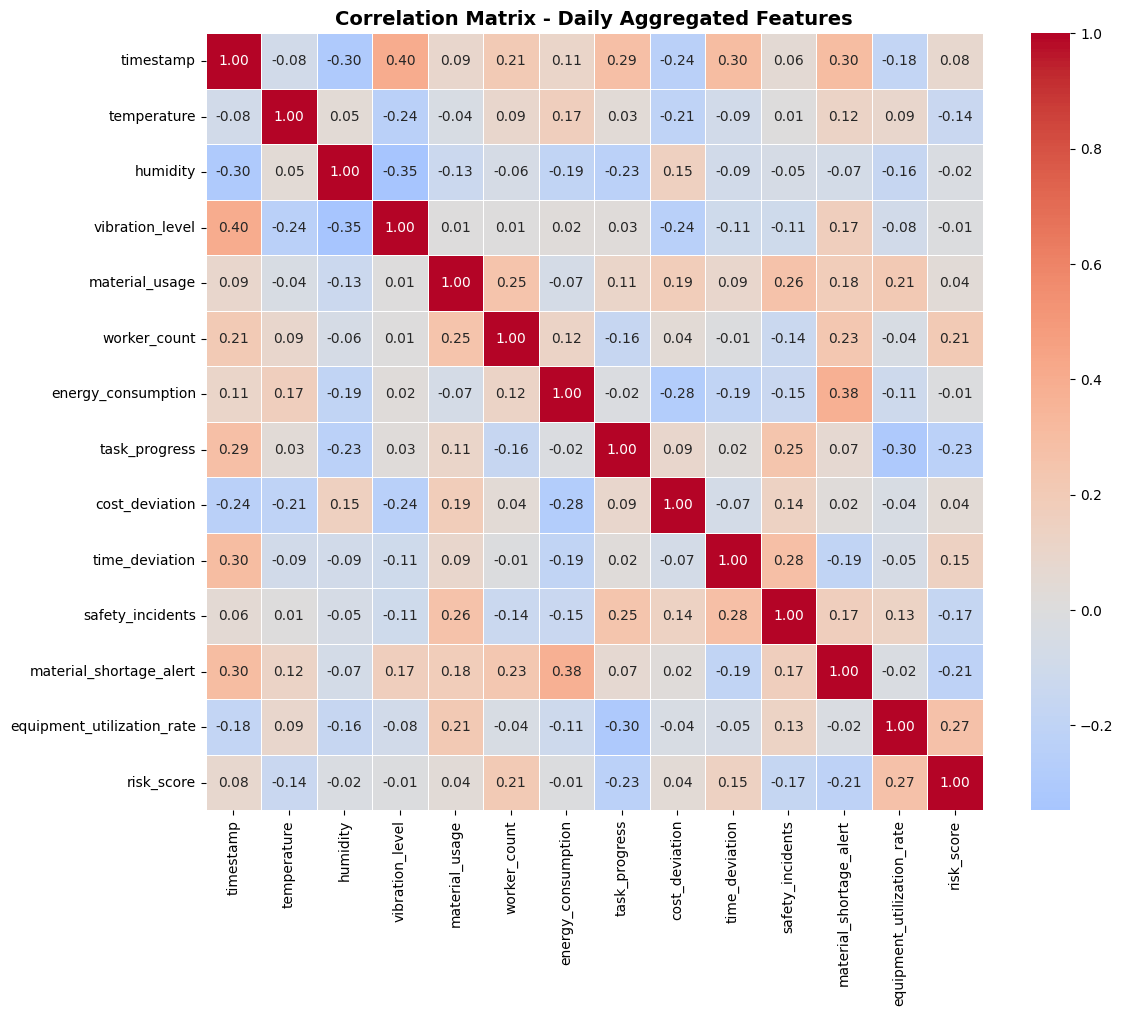

In [106]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix - Daily Aggregated Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

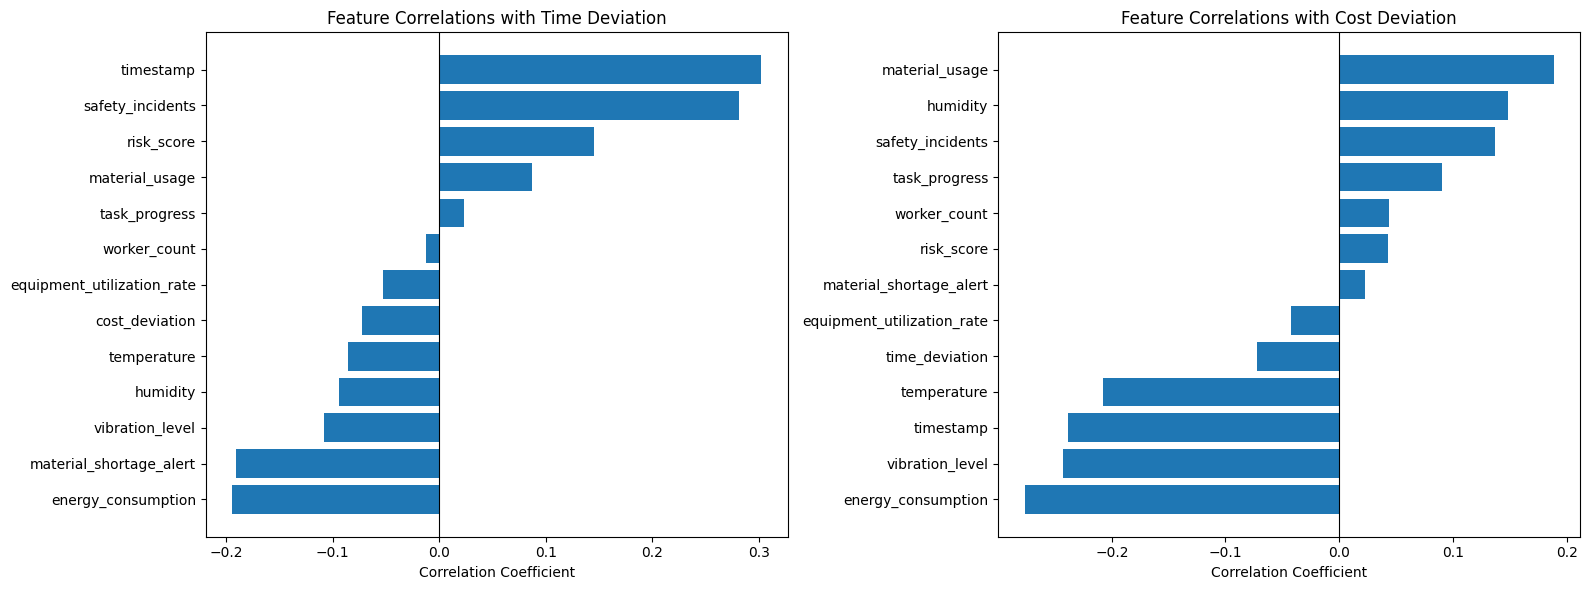

In [107]:
# Visualize just the target variable correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Time deviation correlations
time_corr = correlation_matrix['time_deviation'].drop('time_deviation').sort_values()
axes[0].barh(range(len(time_corr)), time_corr.values)
axes[0].set_yticks(range(len(time_corr)))
axes[0].set_yticklabels(time_corr.index)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Feature Correlations with Time Deviation')
axes[0].axvline(x=0, color='black', linewidth=0.8)

# Cost deviation correlations
cost_corr = correlation_matrix['cost_deviation'].drop('cost_deviation').sort_values()
axes[1].barh(range(len(cost_corr)), cost_corr.values)
axes[1].set_yticks(range(len(cost_corr)))
axes[1].set_yticklabels(cost_corr.index)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Feature Correlations with Cost Deviation')
axes[1].axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

## Derived KPIs + Lags + Rolling Stats

In [108]:
# Start with a copy
df1_daily_features = df1_daily.copy()

print("Starting feature engineering...")
print(f"Original features: {len(df1_daily.columns)}")

# ===== 1. DERIVED KPIs (Efficiency & Velocity Metrics) =====
print("\n1. Creating derived KPIs...")

# Efficiency metrics (ratios)
df1_daily_features['energy_per_worker'] = (
    df1_daily_features['energy_consumption'] / 
    df1_daily_features['worker_count'].replace(0, 1)
)

df1_daily_features['progress_per_worker'] = (
    df1_daily_features['task_progress'] / 
    df1_daily_features['worker_count'].replace(0, 1)
)

df1_daily_features['material_per_progress'] = (
    df1_daily_features['material_usage'] / 
    df1_daily_features['task_progress'].replace(0, 0.01)
)

# Velocity/change features (daily deltas) - FILL WITH 0 for first row
df1_daily_features['task_progress_velocity'] = df1_daily_features['task_progress'].diff().fillna(0)
df1_daily_features['material_usage_change'] = df1_daily_features['material_usage'].diff().fillna(0)
df1_daily_features['energy_change'] = df1_daily_features['energy_consumption'].diff().fillna(0)
df1_daily_features['worker_count_change'] = df1_daily_features['worker_count'].diff().fillna(0)

print(f"  ✓ Created {4 + 4} derived KPIs (change features filled with 0)")

# ===== 2. LAG FEATURES (Historical Values) =====
print("\n2. Creating lag features (t-1, t-2, t-3, t-5, t-7)...")

lag_features = [
    'energy_consumption', 
    'safety_incidents', 
    'material_shortage_alert', 
    'vibration_level', 
    'worker_count', 
    'equipment_utilization_rate',
    'material_usage',
    'risk_score'
]

lag_count = 0
for feature in lag_features:
    # Short-term lags (1-3 days) + Working week lags (5, 7 days)
    for lag in [1, 2, 3, 5, 7]:
        # Create lag and backward fill initial missing values
        df1_daily_features[f'{feature}_lag{lag}'] = (
            df1_daily_features[feature].shift(lag).fillna(0)
        )
        lag_count += 1

print(f"  ✓ Created {lag_count} lag features (includes working week: lag-5, lag-7)")

# ===== SUMMARY =====
total_new_features = len(df1_daily_features.columns) - len(df1_daily.columns)
print(f"\n{'='*60}")
print(f"FEATURE ENGINEERING COMPLETE!")
print(f"{'='*60}")
print(f"Original features: {len(df1_daily.columns)}")
print(f"After engineering: {len(df1_daily_features.columns)}")
print(f"New features created: {total_new_features}")
print(f"Feature types: Derived KPIs + LAG features (NO rolling windows)")

# Check for NaN values (excluding target columns we haven't created yet)
nan_count = df1_daily_features.isnull().sum().sum()
print(f"\nNaN values in features: {nan_count}")
if nan_count > 0:
    print("\nColumns with NaN:")
    print(df1_daily_features.isnull().sum()[df1_daily_features.isnull().sum() > 0])

print(f"{'='*60}")

df1_daily_features.head()

Starting feature engineering...
Original features: 14

1. Creating derived KPIs...
  ✓ Created 8 derived KPIs (change features filled with 0)

2. Creating lag features (t-1, t-2, t-3, t-5, t-7)...
  ✓ Created 40 lag features (includes working week: lag-5, lag-7)

FEATURE ENGINEERING COMPLETE!
Original features: 14
After engineering: 61
New features created: 47
Feature types: Derived KPIs + LAG features (NO rolling windows)

NaN values in features: 0


,timestamp,temperature,humidity,vibration_level,material_usage,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,...,material_usage_lag1,material_usage_lag2,material_usage_lag3,material_usage_lag5,material_usage_lag7,risk_score_lag1,risk_score_lag2,risk_score_lag3,risk_score_lag5,risk_score_lag7
0,2023-01-01,27.430506,50.618980,25.038958,547.145159,27.311111,274.921440,80.356007,-1632.373205,0.393184,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,2023-01-02,27.501768,50.299840,24.722826,549.661577,26.821528,282.277427,100.000000,1346.959193,-7.638648,...,547.145159,0.000000,0.000000,0.0,0.0,51.301386,0.000000,0.000000,0.0,0.0
2,2023-01-03,27.348045,49.794091,25.075719,547.898200,26.837500,271.082649,100.000000,3673.087686,2.168062,...,549.661577,547.145159,0.000000,0.0,0.0,50.556001,51.301386,0.000000,0.0,0.0
3,2023-01-04,27.390419,50.371437,25.204316,556.138394,26.961806,269.378525,100.000000,1759.704807,5.947398,...,547.898200,549.661577,547.145159,0.0,0.0,51.822083,50.556001,51.301386,0.0,0.0
4,2023-01-05,27.432777,50.334395,25.108958,541.152753,27.078472,272.891407,100.000000,3115.083266,-8.146783,...,556.138394,547.898200,549.661577,0.0,0.0,48.935711,51.822083,50.556001,0.0,0.0


## After feature engineering

In [109]:
# Compute correlation matrix with all features
correlation_features = df1_daily_features.corr()

print("=" * 80)
print("CORRELATION ANALYSIS: ENGINEERED FEATURES vs TARGETS")
print("=" * 80)

# Extract correlations with target variables
print("\n=== Top 10 Correlations with TIME DEVIATION ===")
time_corr_features = correlation_features['time_deviation'].drop('time_deviation').sort_values(ascending=False)
print(time_corr_features.head(10))

print("\n=== Top 10 Correlations with COST DEVIATION ===")
cost_corr_features = correlation_features['cost_deviation'].drop('cost_deviation').sort_values(ascending=False)
print(cost_corr_features.head(10))

# Compare with original correlations
print("\n" + "=" * 80)
print("COMPARISON: RAW vs ENGINEERED FEATURES")
print("=" * 80)

print("\n📊 TIME DEVIATION - Best Predictors:")
print("\nOriginal Raw Features (Top 3):")
for i, (feat, corr) in enumerate(time_corr.abs().head(3).items(), 1):
    print(f"  {i}. {feat}: {time_corr[feat]:.4f}")

print("\nWith Engineered Features (Top 3):")
for i, (feat, corr) in enumerate(time_corr_features.abs().head(3).items(), 1):
    print(f"  {i}. {feat}: {time_corr_features[feat]:.4f}")

print("\n💰 COST DEVIATION - Best Predictors:")
print("\nOriginal Raw Features (Top 3):")
for i, (feat, corr) in enumerate(cost_corr.abs().head(3).items(), 1):
    print(f"  {i}. {feat}: {cost_corr[feat]:.4f}")

print("\nWith Engineered Features (Top 3):")
for i, (feat, corr) in enumerate(cost_corr_features.abs().head(3).items(), 1):
    print(f"  {i}. {feat}: {cost_corr_features[feat]:.4f}")

CORRELATION ANALYSIS: ENGINEERED FEATURES vs TARGETS

=== Top 10 Correlations with TIME DEVIATION ===
timestamp                          0.301950
safety_incidents                   0.281522
safety_incidents_lag2              0.274213
material_shortage_alert_lag2       0.253993
safety_incidents_lag5              0.253689
worker_count_lag2                  0.245912
material_usage_lag2                0.232484
equipment_utilization_rate_lag2    0.226724
energy_consumption_lag2            0.223539
risk_score_lag2                    0.222071
Name: time_deviation, dtype: float64

=== Top 10 Correlations with COST DEVIATION ===
material_usage_change              0.297123
material_usage                     0.188552
humidity                           0.148529
safety_incidents                   0.137185
worker_count_change                0.132599
risk_score_lag1                    0.108894
energy_consumption_lag1            0.096960
task_progress_velocity             0.096794
task_progress       

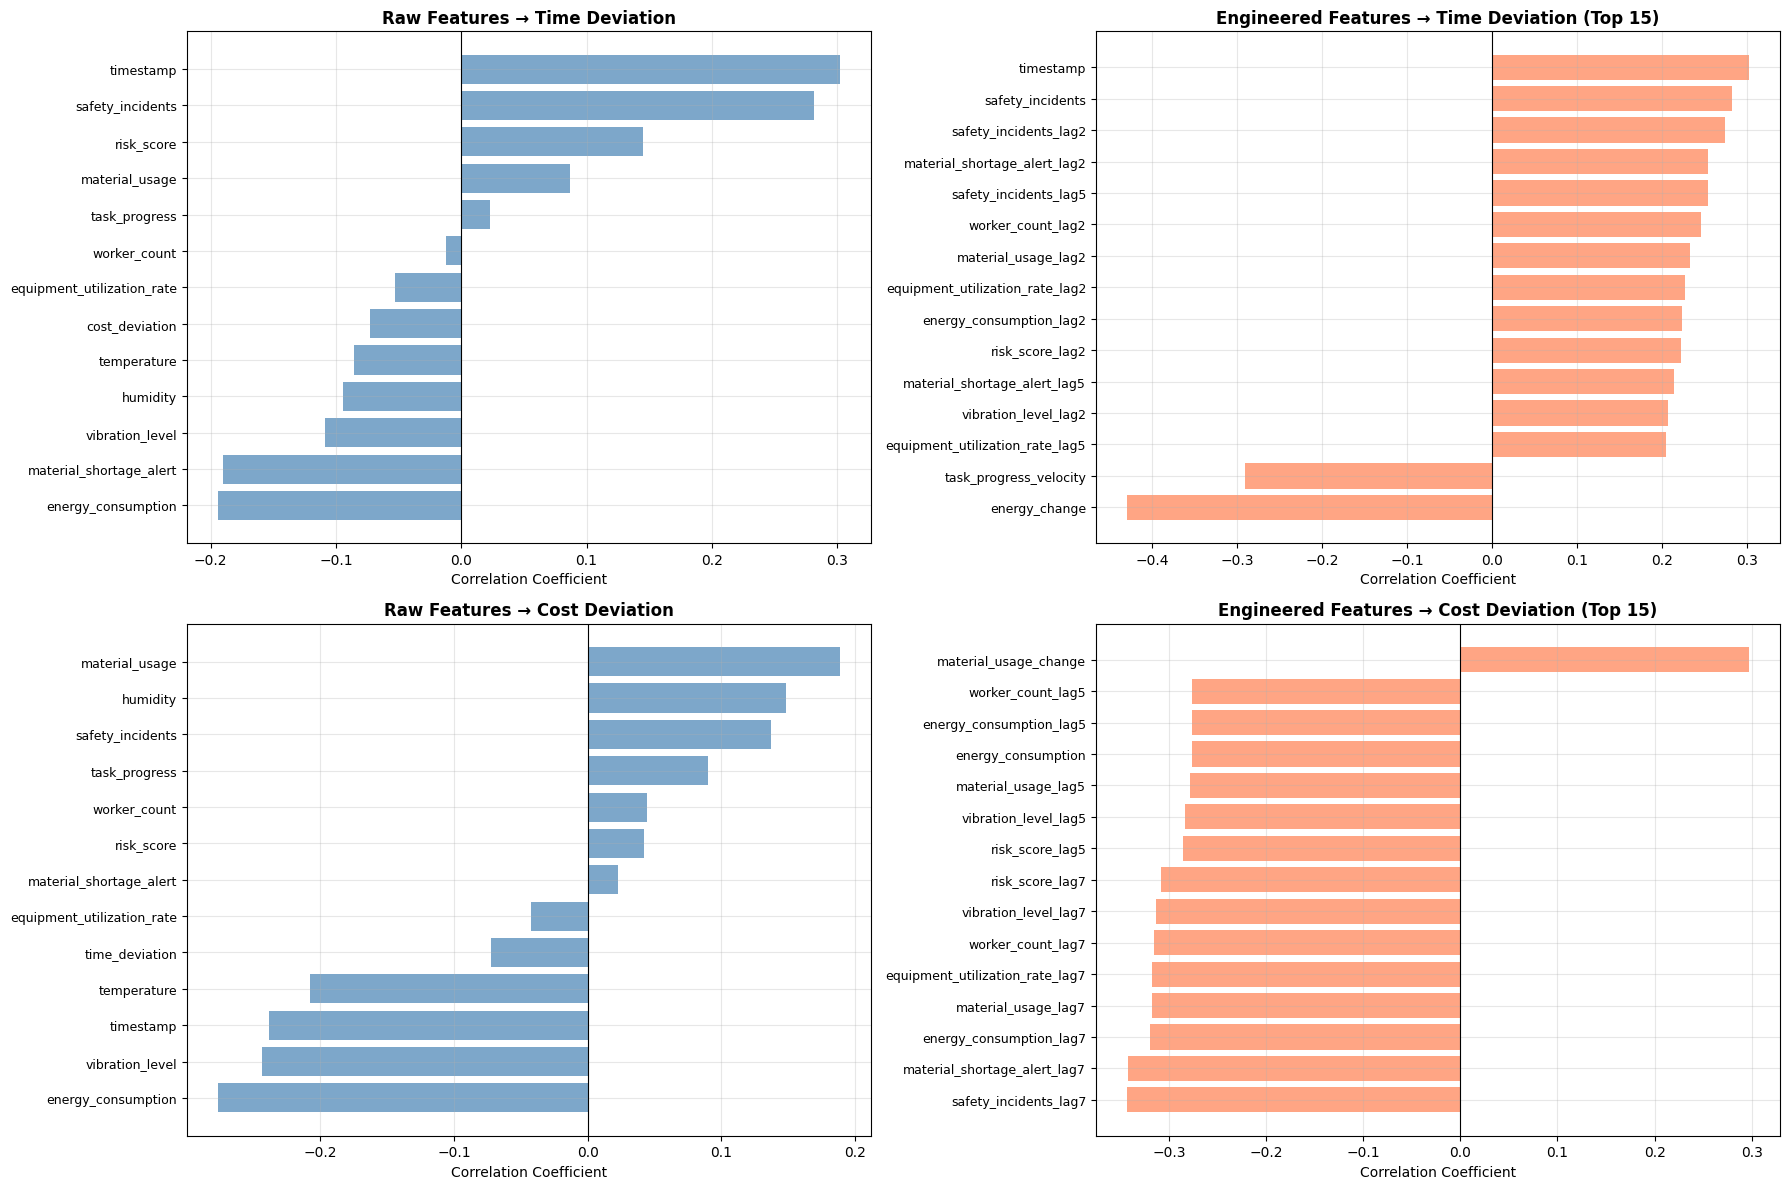


✅ Visualization saved as 'raw_vs_engineered_correlations.png'


In [110]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# TIME DEVIATION - Raw features
time_corr_sorted = time_corr.sort_values()
axes[0, 0].barh(range(len(time_corr_sorted)), time_corr_sorted.values, color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(time_corr_sorted)))
axes[0, 0].set_yticklabels(time_corr_sorted.index, fontsize=9)
axes[0, 0].set_xlabel('Correlation Coefficient')
axes[0, 0].set_title('Raw Features → Time Deviation', fontweight='bold')
axes[0, 0].axvline(x=0, color='black', linewidth=0.8)
axes[0, 0].grid(alpha=0.3)

# TIME DEVIATION - Engineered features (top 15)
time_eng_top = time_corr_features.abs().nlargest(15)
time_eng_top_sorted = time_corr_features[time_eng_top.index].sort_values()
axes[0, 1].barh(range(len(time_eng_top_sorted)), time_eng_top_sorted.values, color='coral', alpha=0.7)
axes[0, 1].set_yticks(range(len(time_eng_top_sorted)))
axes[0, 1].set_yticklabels(time_eng_top_sorted.index, fontsize=9)
axes[0, 1].set_xlabel('Correlation Coefficient')
axes[0, 1].set_title('Engineered Features → Time Deviation (Top 15)', fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linewidth=0.8)
axes[0, 1].grid(alpha=0.3)

# COST DEVIATION - Raw features
cost_corr_sorted = cost_corr.sort_values()
axes[1, 0].barh(range(len(cost_corr_sorted)), cost_corr_sorted.values, color='steelblue', alpha=0.7)
axes[1, 0].set_yticks(range(len(cost_corr_sorted)))
axes[1, 0].set_yticklabels(cost_corr_sorted.index, fontsize=9)
axes[1, 0].set_xlabel('Correlation Coefficient')
axes[1, 0].set_title('Raw Features → Cost Deviation', fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linewidth=0.8)
axes[1, 0].grid(alpha=0.3)

# COST DEVIATION - Engineered features (top 15)
cost_eng_top = cost_corr_features.abs().nlargest(15)
cost_eng_top_sorted = cost_corr_features[cost_eng_top.index].sort_values()
axes[1, 1].barh(range(len(cost_eng_top_sorted)), cost_eng_top_sorted.values, color='coral', alpha=0.7)
axes[1, 1].set_yticks(range(len(cost_eng_top_sorted)))
axes[1, 1].set_yticklabels(cost_eng_top_sorted.index, fontsize=9)
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_title('Engineered Features → Cost Deviation (Top 15)', fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linewidth=0.8)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('raw_vs_engineered_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'raw_vs_engineered_correlations.png'")

# Target generation and getting data ready

In [111]:
# Create targets with 7% threshold for significant overruns
# This captures meaningful deviations and reduces noise from small fluctuations

time_threshold = 0.07  # 7% deviation threshold for time
cost_threshold = 0.07  # 7% deviation threshold for cost

print("=" * 80)
print("TARGET GENERATION: 7% Threshold for Significant Overruns")
print("=" * 80)
print(f"\nTime threshold: {time_threshold * 100:.0f}% deviation")
print(f"Cost threshold: {cost_threshold * 100:.0f}% deviation")
print("\n💡 Only flagging significant overruns (>7%) to reduce noise")

# Create targets - use where() to preserve NaN
shifted_time = df1_daily_features['time_deviation'].shift(-1)
df1_daily_features['time_overrun_next'] = (shifted_time > time_threshold).where(shifted_time.notna()).astype('Int64')

shifted_cost = df1_daily_features['cost_deviation'].shift(-1)
df1_daily_features['cost_overrun_next'] = (shifted_cost > cost_threshold).where(shifted_cost.notna()).astype('Int64')

# Show distribution
print(f"\n📊 Target Distribution Preview:")
print(f"   Time overrun > 7%: {df1_daily_features['time_overrun_next'].sum()} cases")
print(f"   Cost overrun > 7%: {df1_daily_features['cost_overrun_next'].sum()} cases")
print("\n" + "=" * 80)

TARGET GENERATION: 7% Threshold for Significant Overruns

Time threshold: 7% deviation
Cost threshold: 7% deviation

💡 Only flagging significant overruns (>7%) to reduce noise

📊 Target Distribution Preview:
   Time overrun > 7%: 22 cases
   Cost overrun > 7%: 20 cases



In [112]:
# Let's check what's happening with the shift
print("Last 5 rows of time_deviation:")
print(df1_daily_features['time_deviation'].tail(5))

print("\nShifted time_deviation (shift -1):")
print(df1_daily_features['time_deviation'].shift(-1).tail(5))

print("\nLast 5 rows of targets:")
print(df1_daily_features[['time_overrun_next', 'cost_overrun_next']].tail(5))

print("\nChecking if last target values are actually NaN before conversion:")
print("Type of (shift(-1) > 0) for last row:", type((df1_daily_features['time_deviation'].shift(-1) > 0).iloc[-1]))
print("Value:", (df1_daily_features['time_deviation'].shift(-1) > 0).iloc[-1])

Last 5 rows of time_deviation:
30    9.383164
31    4.837937
32    2.147449
33    6.173708
34   -2.289109
Name: time_deviation, dtype: float64

Shifted time_deviation (shift -1):
30    4.837937
31    2.147449
32    6.173708
33   -2.289109
34         NaN
Name: time_deviation, dtype: float64

Last 5 rows of targets:
    time_overrun_next  cost_overrun_next
30                  1                  0
31                  1                  1
32                  1                  1
33                  0                  0
34               <NA>               <NA>

Checking if last target values are actually NaN before conversion:
Type of (shift(-1) > 0) for last row: <class 'numpy.bool'>
Value: False


# 🔍 DIAGNOSTIC ANALYSIS: Daily Data Quality (7% Threshold)

Let's analyze the quality of our daily aggregated data with the 7% threshold for significant overruns.

In [113]:
print("=" * 80)
print("DIAGNOSTIC 1: TARGET STABILITY - How often does overrun status flip?")
print("=" * 80)

# Check how stable the target is day-to-day
time_overrun = df1_daily_features['time_overrun_next'].dropna()
cost_overrun = df1_daily_features['cost_overrun_next'].dropna()

# Count consecutive changes (flipping between 0 and 1)
time_flips = (time_overrun.diff() != 0).sum()
cost_flips = (cost_overrun.diff() != 0).sum()

print(f"\nTime Overrun Target:")
print(f"  Total samples: {len(time_overrun)}")
print(f"  Status flips: {time_flips} times")
print(f"  Flip rate: {time_flips/len(time_overrun)*100:.1f}%")
if time_flips > 0:
    print(f"  Average consecutive days same status: {len(time_overrun)/time_flips:.1f} days")

print(f"\nCost Overrun Target:")
print(f"  Total samples: {len(cost_overrun)}")
print(f"  Status flips: {cost_flips} times")
print(f"  Flip rate: {cost_flips/len(cost_overrun)*100:.1f}%")
if cost_flips > 0:
    print(f"  Average consecutive days same status: {len(cost_overrun)/cost_flips:.1f} days")

print("\n💡 Interpretation (Daily Data with 7% Threshold):")
print("   - High flip rate (>60%) = Very noisy targets, hard to predict")
print("   - Medium flip rate (30-60%) = Moderate variability, expect some challenge")
print("   - Low flip rate (<30%) = Stable patterns, better for learning")
print("   - With 7% threshold, expect MODERATE flip rate (between 0% and 15% thresholds)")

DIAGNOSTIC 1: TARGET STABILITY - How often does overrun status flip?

Time Overrun Target:
  Total samples: 34
  Status flips: 18 times
  Flip rate: 52.9%
  Average consecutive days same status: 1.9 days

Cost Overrun Target:
  Total samples: 34
  Status flips: 15 times
  Flip rate: 44.1%
  Average consecutive days same status: 2.3 days

💡 Interpretation (Daily Data with 7% Threshold):
   - High flip rate (>60%) = Very noisy targets, hard to predict
   - Medium flip rate (30-60%) = Moderate variability, expect some challenge
   - Low flip rate (<30%) = Stable patterns, better for learning
   - With 7% threshold, expect MODERATE flip rate (between 0% and 15% thresholds)


In [114]:
print("=" * 80)
print("DIAGNOSTIC 2: FEATURE CORRELATION WITH TARGETS")
print("=" * 80)

# Check how well engineered features correlate with the BINARY targets (not continuous deviation)
# This is what the model actually tries to predict

# Compute correlation with binary targets
time_target_corr = df1_daily_features.corr()['time_overrun_next'].dropna()
cost_target_corr = df1_daily_features.corr()['cost_overrun_next'].dropna()

# Exclude the target itself
time_target_corr = time_target_corr.drop(['time_overrun_next', 'cost_overrun_next'], errors='ignore')
cost_target_corr = cost_target_corr.drop(['time_overrun_next', 'cost_overrun_next'], errors='ignore')

print(f"\n📊 TIME OVERRUN NEXT - Top 10 Correlated Features:")
print("-" * 80)
for i, (feat, corr) in enumerate(time_target_corr.abs().nlargest(10).items(), 1):
    actual_corr = time_target_corr[feat]
    print(f"{i:2d}. {feat:40s} | Correlation: {actual_corr:7.4f}")

print(f"\n💰 COST OVERRUN NEXT - Top 10 Correlated Features:")
print("-" * 80)
for i, (feat, corr) in enumerate(cost_target_corr.abs().nlargest(10).items(), 1):
    actual_corr = cost_target_corr[feat]
    print(f"{i:2d}. {feat:40s} | Correlation: {actual_corr:7.4f}")

print("\n💡 Interpretation (Daily Data):")
print("   - Correlation > 0.2: Strong relationship, good for prediction")
print("   - Correlation 0.1-0.2: Moderate relationship, helpful")
print("   - Correlation < 0.1: Weak relationship, limited predictive power")

DIAGNOSTIC 2: FEATURE CORRELATION WITH TARGETS

📊 TIME OVERRUN NEXT - Top 10 Correlated Features:
--------------------------------------------------------------------------------
 1. energy_consumption                       | Correlation:  0.3467
 2. energy_per_worker                        | Correlation:  0.3358
 3. vibration_level                          | Correlation:  0.3094
 4. humidity                                 | Correlation: -0.3068
 5. cost_deviation                           | Correlation: -0.3061
 6. worker_count_change                      | Correlation: -0.2751
 7. energy_change                            | Correlation:  0.2611
 8. worker_count_lag1                        | Correlation:  0.2587
 9. progress_per_worker                      | Correlation:  0.2446
10. material_usage_lag1                      | Correlation:  0.2413

💰 COST OVERRUN NEXT - Top 10 Correlated Features:
--------------------------------------------------------------------------------
 1. mater

In [115]:
print("=" * 80)
print("DIAGNOSTIC 3: CLASS BALANCE - Are targets too imbalanced?")
print("=" * 80)

# Check class distribution
time_overrun_counts = df1_daily_features['time_overrun_next'].value_counts()
cost_overrun_counts = df1_daily_features['cost_overrun_next'].value_counts()

print(f"\n📊 TIME OVERRUN CLASS DISTRIBUTION:")
print("-" * 80)
print(f"Class 0 (No overrun): {time_overrun_counts.get(0, 0)} samples ({time_overrun_counts.get(0, 0)/len(time_overrun)*100:.1f}%)")
print(f"Class 1 (Overrun):    {time_overrun_counts.get(1, 0)} samples ({time_overrun_counts.get(1, 0)/len(time_overrun)*100:.1f}%)")
imbalance_ratio_time = time_overrun_counts.get(1, 0) / time_overrun_counts.get(0, 1)
print(f"Imbalance ratio: {imbalance_ratio_time:.2f} (Class 1 / Class 0)")

print(f"\n💰 COST OVERRUN CLASS DISTRIBUTION:")
print("-" * 80)
print(f"Class 0 (No overrun): {cost_overrun_counts.get(0, 0)} samples ({cost_overrun_counts.get(0, 0)/len(cost_overrun)*100:.1f}%)")
print(f"Class 1 (Overrun):    {cost_overrun_counts.get(1, 0)} samples ({cost_overrun_counts.get(1, 0)/len(cost_overrun)*100:.1f}%)")
imbalance_ratio_cost = cost_overrun_counts.get(1, 0) / cost_overrun_counts.get(0, 1)
print(f"Imbalance ratio: {imbalance_ratio_cost:.2f} (Class 1 / Class 0)")

print("\n💡 Interpretation:")
print("   - Ratio 0.5-2.0: Well balanced, good for learning")
print("   - Ratio 0.2-0.5 or 2.0-5.0: Moderate imbalance, handle with weights")
print("   - Ratio <0.2 or >5.0: Severe imbalance, may need special techniques")

DIAGNOSTIC 3: CLASS BALANCE - Are targets too imbalanced?

📊 TIME OVERRUN CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
Class 0 (No overrun): 12 samples (35.3%)
Class 1 (Overrun):    22 samples (64.7%)
Imbalance ratio: 1.83 (Class 1 / Class 0)

💰 COST OVERRUN CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
Class 0 (No overrun): 14 samples (41.2%)
Class 1 (Overrun):    20 samples (58.8%)
Imbalance ratio: 1.43 (Class 1 / Class 0)

💡 Interpretation:
   - Ratio 0.5-2.0: Well balanced, good for learning
   - Ratio 0.2-0.5 or 2.0-5.0: Moderate imbalance, handle with weights
   - Ratio <0.2 or >5.0: Severe imbalance, may need special techniques


In [116]:
print("=" * 80)
print("DIAGNOSTIC 4: SIGNAL-TO-NOISE - How much does deviation change daily?")
print("=" * 80)

# Check the magnitude of daily changes in deviation
time_dev_change = df1_daily_features['time_deviation'].diff().abs()
cost_dev_change = df1_daily_features['cost_deviation'].diff().abs()

print(f"\n📊 TIME DEVIATION - Daily Changes:")
print("-" * 80)
print(f"Mean absolute change per day: {time_dev_change.mean():.4f}")
print(f"Std of changes: {time_dev_change.std():.4f}")
print(f"75th percentile change: {time_dev_change.quantile(0.75):.4f}")
print(f"95th percentile change: {time_dev_change.quantile(0.95):.4f}")

print(f"\n💰 COST DEVIATION - Daily Changes:")
print("-" * 80)
print(f"Mean absolute change per day: {cost_dev_change.mean():.4f}")
print(f"Std of changes: {cost_dev_change.std():.4f}")
print(f"75th percentile change: {cost_dev_change.quantile(0.75):.4f}")
print(f"95th percentile change: {cost_dev_change.quantile(0.95):.4f}")

# Compare to overall deviation range
time_range = df1_daily_features['time_deviation'].max() - df1_daily_features['time_deviation'].min()
cost_range = df1_daily_features['cost_deviation'].max() - df1_daily_features['cost_deviation'].min()

print(f"\n📈 Deviation Ranges:")
print(f"Time deviation range: {time_range:.4f}")
print(f"Cost deviation range: {cost_range:.4f}")
print(f"\nSignal-to-Noise (range / mean_change):")
if time_dev_change.mean() > 0:
    print(f"Time: {time_range / time_dev_change.mean():.1f}x")
if cost_dev_change.mean() > 0:
    print(f"Cost: {cost_range / cost_dev_change.mean():.1f}x")

print("\n💡 Interpretation (Daily Data):")
print("   - High ratio (>20): Good signal, daily trends are meaningful")
print("   - Medium ratio (5-20): Moderate signal, some predictive value")
print("   - Low ratio (<5): Noisy signal, daily changes may be erratic")

DIAGNOSTIC 4: SIGNAL-TO-NOISE - How much does deviation change daily?

📊 TIME DEVIATION - Daily Changes:
--------------------------------------------------------------------------------
Mean absolute change per day: 6.8730
Std of changes: 4.1796
75th percentile change: 9.7017
95th percentile change: 14.5878

💰 COST DEVIATION - Daily Changes:
--------------------------------------------------------------------------------
Mean absolute change per day: 3007.1839
Std of changes: 2334.1387
75th percentile change: 4987.0275
95th percentile change: 6785.1594

📈 Deviation Ranges:
Time deviation range: 18.4215
Cost deviation range: 8583.9573

Signal-to-Noise (range / mean_change):
Time: 2.7x
Cost: 2.9x

💡 Interpretation (Daily Data):
   - High ratio (>20): Good signal, daily trends are meaningful
   - Medium ratio (5-20): Moderate signal, some predictive value
   - Low ratio (<5): Noisy signal, daily changes may be erratic
75th percentile change: 4987.0275
95th percentile change: 6785.1594

📈 

DIAGNOSTIC 5: VISUALIZATION - Target patterns over time


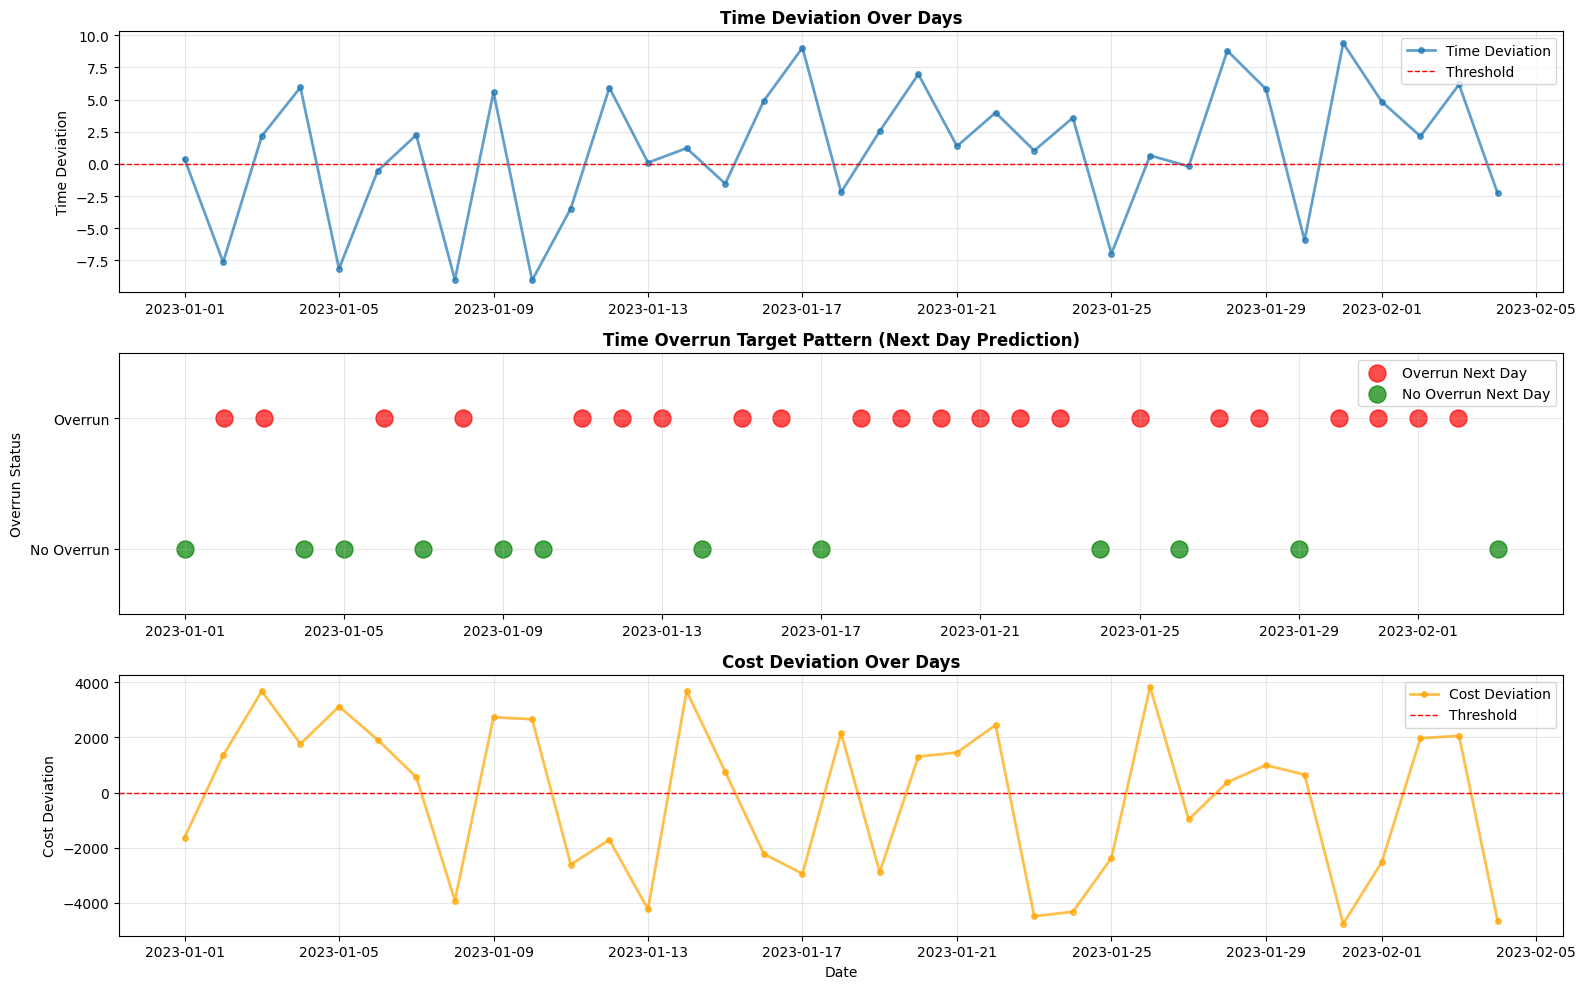


✅ Visualization saved as 'daily_target_patterns.png'

💡 Look for:
   - Are overrun periods clustered in sequences or scattered randomly?
   - Do deviation trends show clear patterns/trends or erratic jumps?
   - Does the target show periods of stability or constant flipping?
   - With daily data, we expect more stable patterns than hourly


In [117]:
print("=" * 80)
print("DIAGNOSTIC 5: VISUALIZATION - Target patterns over time")
print("=" * 80)

# Visualize how targets change over time
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Time deviation and overrun
axes[0].plot(df1_daily_features['timestamp'], df1_daily_features['time_deviation'], 
             label='Time Deviation', alpha=0.7, linewidth=2, marker='o', markersize=4)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, label='Threshold')
axes[0].set_ylabel('Time Deviation')
axes[0].set_title('Time Deviation Over Days', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Time overrun target (next day)
overrun_times = df1_daily_features[df1_daily_features['time_overrun_next'] == 1]['timestamp']
axes[1].scatter(overrun_times, [1]*len(overrun_times), c='red', marker='o', s=150, label='Overrun Next Day', alpha=0.7)
no_overrun_times = df1_daily_features[df1_daily_features['time_overrun_next'] == 0]['timestamp']
axes[1].scatter(no_overrun_times, [0]*len(no_overrun_times), c='green', marker='o', s=150, label='No Overrun Next Day', alpha=0.7)
axes[1].set_ylabel('Overrun Status')
axes[1].set_ylim(-0.5, 1.5)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['No Overrun', 'Overrun'])
axes[1].set_title('Time Overrun Target Pattern (Next Day Prediction)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Cost deviation and overrun
axes[2].plot(df1_daily_features['timestamp'], df1_daily_features['cost_deviation'], 
             label='Cost Deviation', alpha=0.7, linewidth=2, color='orange', marker='o', markersize=4)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1, label='Threshold')
axes[2].set_ylabel('Cost Deviation')
axes[2].set_xlabel('Date')
axes[2].set_title('Cost Deviation Over Days', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('daily_target_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'daily_target_patterns.png'")
print("\n💡 Look for:")
print("   - Are overrun periods clustered in sequences or scattered randomly?")
print("   - Do deviation trends show clear patterns/trends or erratic jumps?")
print("   - Does the target show periods of stability or constant flipping?")
print("   - With daily data, we expect more stable patterns than hourly")

## 📋 DIAGNOSTIC SUMMARY - Daily Data Quality Assessment (7% Threshold)

**Based on the diagnostics above, evaluate:**

1. **Target Stability**: 
   - Good: Flip rate <30% (targets show meaningful periods)
   - Moderate: 30-60% (some instability but workable)
   - Poor: >60% (too volatile, targets are unpredictable)
   - **Expected**: 7% threshold should balance stability and sufficient positive cases

2. **Feature Correlation**: 
   - Good: Max correlation >0.2 (features have predictive power)
   - Moderate: 0.1-0.2 (weak but potentially useful signals)
   - Poor: <0.1 (features don't capture target behavior)

3. **Class Balance**: 
   - Check if severe imbalance needs special handling
   - Ratio 0.3-3.0 is generally workable with class weights
   - **Expected change**: More positive cases than 15%, fewer than 0%

4. **Signal-to-Noise**: 
   - Good: Ratio >20 (daily trends are meaningful)
   - Moderate: 5-20 (some signal but noisy)
   - Poor: <5 (changes are mostly random)

5. **Visual Patterns**: 
   - Look for clusters of overrun/no-overrun periods
   - Daily data should show clearer trends than hourly
   - **7% threshold**: Should see moderate separation in overrun periods

**Expected Benefits of 7% Threshold:**
With construction projects tracked day-by-day and 7% deviation threshold:
- **Balance**: More positive cases than 15% (better for learning)
- **Meaningful signal**: 7% deviation is still a significant business threshold
- **Better than 0%**: Less noise than flagging every tiny deviation
- **Middle ground**: Compromise between stability and sample count

## Feature Selection

Select top 10 features for each model based on correlation analysis (Derived KPIs + LAG features, NO rolling windows).

In [118]:
# Feature selection based on correlation with targets
# Select top 10 features for each model (simplified approach)

print("=" * 80)
print("FEATURE SELECTION: Top 10 Features for Each Model")
print("=" * 80)

# Get correlations with targets (absolute values for ranking)
# Exclude: timestamp, time_deviation, cost_deviation, time_overrun_next, cost_overrun_next
columns_to_exclude = ['timestamp', 'time_deviation', 'cost_deviation', 'time_overrun_next', 'cost_overrun_next']
available_features = [col for col in correlation_features.columns if col not in columns_to_exclude]

time_correlations = correlation_features.loc[available_features, 'time_deviation'].abs()
cost_correlations = correlation_features.loc[available_features, 'cost_deviation'].abs()

# Select top 10 features for TIME model
top_10_time_features = time_correlations.nlargest(10).index.tolist()

print("\n📊 TOP 10 FEATURES FOR TIME OVERRUN MODEL:")
print("-" * 80)
for i, feature in enumerate(top_10_time_features, 1):
    corr_value = correlation_features.loc[feature, 'time_deviation']
    print(f"{i:2d}. {feature:40s} | Correlation: {corr_value:7.4f}")

# Select top 10 features for COST model
top_10_cost_features = cost_correlations.nlargest(10).index.tolist()

print("\n💰 TOP 10 FEATURES FOR COST OVERRUN MODEL:")
print("-" * 80)
for i, feature in enumerate(top_10_cost_features, 1):
    corr_value = correlation_features.loc[feature, 'cost_deviation']
    print(f"{i:2d}. {feature:40s} | Correlation: {corr_value:7.4f}")

# Check overlap between the two feature sets
overlap = set(top_10_time_features) & set(top_10_cost_features)
print("\n" + "=" * 80)
print(f"OVERLAP: {len(overlap)} features appear in both models")
print("=" * 80)
if overlap:
    print("Common features:", overlap)

print(f"\n✅ Feature selection complete!")
print(f"   - Time model: {len(top_10_time_features)} features")
print(f"   - Cost model: {len(top_10_cost_features)} features")
print(f"\n🚫 Excluded columns: {columns_to_exclude}")
print("\n💡 Using 10 features for simpler models with 34 samples")

FEATURE SELECTION: Top 10 Features for Each Model

📊 TOP 10 FEATURES FOR TIME OVERRUN MODEL:
--------------------------------------------------------------------------------
 1. energy_change                            | Correlation: -0.4291
 2. task_progress_velocity                   | Correlation: -0.2907
 3. safety_incidents                         | Correlation:  0.2815
 4. safety_incidents_lag2                    | Correlation:  0.2742
 5. material_shortage_alert_lag2             | Correlation:  0.2540
 6. safety_incidents_lag5                    | Correlation:  0.2537
 7. worker_count_lag2                        | Correlation:  0.2459
 8. material_usage_lag2                      | Correlation:  0.2325
 9. equipment_utilization_rate_lag2          | Correlation:  0.2267
10. energy_consumption_lag2                  | Correlation:  0.2235

💰 TOP 10 FEATURES FOR COST OVERRUN MODEL:
--------------------------------------------------------------------------------
 1. safety_incidents_l

## 🎯 SPECIALIZED FEATURE SETS

Based on analysis, we're creating **different feature sets** for TIME vs COST models:
- **TIME**: LAG features ONLY (derived KPIs hurt Stacking ensemble performance)
- **COST**: Derived KPIs + LAG features (derived KPIs improved LR performance)

In [119]:
print("=" * 80)
print("CREATING SPECIALIZED FEATURE SETS FOR TIME vs COST")
print("=" * 80)

# Define derived KPI feature names (to exclude for TIME model)
derived_kpi_features = [
    'energy_per_worker',
    'progress_per_worker', 
    'material_per_progress',
    'task_progress_velocity',
    'material_usage_change',
    'energy_change',
    'worker_count_change'
]

# TIME MODEL: LAG-ONLY features
# Get all available features excluding derived KPIs
time_available_features = [
    col for col in available_features 
    if col not in derived_kpi_features
]

# Recompute correlations for TIME with LAG-only features
time_correlations_lag_only = correlation_features.loc[time_available_features, 'time_deviation'].abs()
top_10_time_features_lag_only = time_correlations_lag_only.nlargest(10).index.tolist()

print("\n📊 TIME MODEL - LAG-ONLY TOP 10 FEATURES:")
print("-" * 80)
for i, feature in enumerate(top_10_time_features_lag_only, 1):
    corr_value = correlation_features.loc[feature, 'time_deviation']
    print(f"{i:2d}. {feature:40s} | Correlation: {corr_value:7.4f}")

# COST MODEL: Keep Derived + LAG features (already computed above)
print("\n💰 COST MODEL - DERIVED + LAG TOP 10 FEATURES:")
print("-" * 80)
for i, feature in enumerate(top_10_cost_features, 1):
    corr_value = correlation_features.loc[feature, 'cost_deviation']
    # Mark if it's a derived KPI
    marker = " 🔧 (Derived KPI)" if feature in derived_kpi_features else ""
    print(f"{i:2d}. {feature:40s} | Correlation: {corr_value:7.4f}{marker}")

print("\n" + "=" * 80)
print("SUMMARY:")
print("=" * 80)
print(f"TIME model: {len(top_10_time_features_lag_only)} LAG-ONLY features")
print(f"COST model: {len(top_10_cost_features)} DERIVED+LAG features")

# Count derived KPIs in COST features
cost_derived_count = sum(1 for f in top_10_cost_features if f in derived_kpi_features)
print(f"\nCOST model includes {cost_derived_count} derived KPI feature(s)")

print("\n💡 Strategy: Different feature sets for different targets!")
print("   TIME: Simple lag features work best with Stacking")
print("   COST: Business metrics (derived KPIs) improve Logistic Regression")

CREATING SPECIALIZED FEATURE SETS FOR TIME vs COST

📊 TIME MODEL - LAG-ONLY TOP 10 FEATURES:
--------------------------------------------------------------------------------
 1. safety_incidents                         | Correlation:  0.2815
 2. safety_incidents_lag2                    | Correlation:  0.2742
 3. material_shortage_alert_lag2             | Correlation:  0.2540
 4. safety_incidents_lag5                    | Correlation:  0.2537
 5. worker_count_lag2                        | Correlation:  0.2459
 6. material_usage_lag2                      | Correlation:  0.2325
 7. equipment_utilization_rate_lag2          | Correlation:  0.2267
 8. energy_consumption_lag2                  | Correlation:  0.2235
 9. risk_score_lag2                          | Correlation:  0.2221
10. material_shortage_alert_lag5             | Correlation:  0.2138

💰 COST MODEL - DERIVED + LAG TOP 10 FEATURES:
--------------------------------------------------------------------------------
 1. safety_inciden

In [120]:
print(df1_daily_features.iloc[-1])

timestamp            2023-02-04 00:00:00
temperature                    27.348481
humidity                        50.12371
vibration_level                25.658077
material_usage                540.837476
                            ...         
risk_score_lag3                51.315766
risk_score_lag5                49.581772
risk_score_lag7                50.564319
time_overrun_next                   <NA>
cost_overrun_next                   <NA>
Name: 34, Length: 63, dtype: object


## Prepare Final Dataset

Remove the last row (has NaN target) and verify data is ready for modeling.

In [121]:
# Remove last row (has NaN target due to shift(-1))
df_model = df1_daily_features[:-1].copy()

print("=" * 80)
print("DATA PREPARATION SUMMARY")
print("=" * 80)

print(f"\nOriginal daily data: {len(df1_daily)} rows")
print(f"After feature engineering: {len(df1_daily_features)} rows")
print(f"After removing last row: {len(df_model)} rows")

# Verify no NaN values in our modeling data
nan_check = df_model.isnull().sum()
total_nans = nan_check.sum()

print(f"\n✅ NaN Check: {total_nans} total NaN values")
if total_nans > 0:
    print("\nWarning: Found NaN values in:")
    print(nan_check[nan_check > 0])
else:
    print("   All features are complete - ready for modeling!")

# Verify target distributions
print("\n📊 TARGET CLASS DISTRIBUTION:")
print("-" * 80)
print(f"Time Overrun Next:")
print(f"  Class 0 (No overrun): {(df_model['time_overrun_next'] == 0).sum()} samples ({(df_model['time_overrun_next'] == 0).sum() / len(df_model) * 100:.1f}%)")
print(f"  Class 1 (Overrun):    {(df_model['time_overrun_next'] == 1).sum()} samples ({(df_model['time_overrun_next'] == 1).sum() / len(df_model) * 100:.1f}%)")

print(f"\nCost Overrun Next:")
print(f"  Class 0 (No overrun): {(df_model['cost_overrun_next'] == 0).sum()} samples ({(df_model['cost_overrun_next'] == 0).sum() / len(df_model) * 100:.1f}%)")
print(f"  Class 1 (Overrun):    {(df_model['cost_overrun_next'] == 1).sum()} samples ({(df_model['cost_overrun_next'] == 1).sum() / len(df_model) * 100:.1f}%)")

print("\n" + "=" * 80)
print(f"✅ Dataset ready for train/val/test split ({len(df_model)} samples)")
print("=" * 80)

df_model.head()

DATA PREPARATION SUMMARY

Original daily data: 35 rows
After feature engineering: 35 rows
After removing last row: 34 rows

✅ NaN Check: 0 total NaN values
   All features are complete - ready for modeling!

📊 TARGET CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
Time Overrun Next:
  Class 0 (No overrun): 12 samples (35.3%)
  Class 1 (Overrun):    22 samples (64.7%)

Cost Overrun Next:
  Class 0 (No overrun): 14 samples (41.2%)
  Class 1 (Overrun):    20 samples (58.8%)

✅ Dataset ready for train/val/test split (34 samples)


,timestamp,temperature,humidity,vibration_level,material_usage,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,...,material_usage_lag3,material_usage_lag5,material_usage_lag7,risk_score_lag1,risk_score_lag2,risk_score_lag3,risk_score_lag5,risk_score_lag7,time_overrun_next,cost_overrun_next
0,2023-01-01,27.430506,50.618980,25.038958,547.145159,27.311111,274.921440,80.356007,-1632.373205,0.393184,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,1
1,2023-01-02,27.501768,50.299840,24.722826,549.661577,26.821528,282.277427,100.000000,1346.959193,-7.638648,...,0.000000,0.0,0.0,51.301386,0.000000,0.000000,0.0,0.0,1,1
2,2023-01-03,27.348045,49.794091,25.075719,547.898200,26.837500,271.082649,100.000000,3673.087686,2.168062,...,0.000000,0.0,0.0,50.556001,51.301386,0.000000,0.0,0.0,1,1
3,2023-01-04,27.390419,50.371437,25.204316,556.138394,26.961806,269.378525,100.000000,1759.704807,5.947398,...,547.145159,0.0,0.0,51.822083,50.556001,51.301386,0.0,0.0,0,1
4,2023-01-05,27.432777,50.334395,25.108958,541.152753,27.078472,272.891407,100.000000,3115.083266,-8.146783,...,549.661577,0.0,0.0,48.935711,51.822083,50.556001,0.0,0.0,0,1


# Train/Val/Test Split

Chronological split to prevent data leakage. We'll create separate datasets for time and cost models.

In [122]:
# Chronological split: 70% train, 15% val, 15% test
# With ~34 samples: Train~24, Val~5, Test~5

n_samples = len(df_model)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)
# test_size is the remainder

print("=" * 80)
print("TRAIN/VAL/TEST SPLIT - CHRONOLOGICAL")
print("=" * 80)

print(f"\nTotal samples: {n_samples}")
print(f"Train size: {train_size} samples ({train_size/n_samples*100:.1f}%)")
print(f"Val size:   {val_size} samples ({val_size/n_samples*100:.1f}%)")
print(f"Test size:  {n_samples - train_size - val_size} samples ({(n_samples - train_size - val_size)/n_samples*100:.1f}%)")

# Split indices
train_end = train_size
val_end = train_size + val_size

# Split the data chronologically
df_train = df_model.iloc[:train_end].copy()
df_val = df_model.iloc[train_end:val_end].copy()
df_test = df_model.iloc[val_end:].copy()

print("\n📅 DATE RANGES:")
print("-" * 80)
print(f"Train: {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")
print(f"Val:   {df_val['timestamp'].min()} to {df_val['timestamp'].max()}")
print(f"Test:  {df_test['timestamp'].min()} to {df_test['timestamp'].max()}")

print("\n" + "=" * 80)
print("✅ Chronological split complete - no data leakage!")
print("=" * 80)

TRAIN/VAL/TEST SPLIT - CHRONOLOGICAL

Total samples: 34
Train size: 23 samples (67.6%)
Val size:   5 samples (14.7%)
Test size:  6 samples (17.6%)

📅 DATE RANGES:
--------------------------------------------------------------------------------
Train: 2023-01-01 00:00:00 to 2023-01-23 00:00:00
Val:   2023-01-24 00:00:00 to 2023-01-28 00:00:00
Test:  2023-01-29 00:00:00 to 2023-02-03 00:00:00

✅ Chronological split complete - no data leakage!


## TIME Model - Feature/Target Split

In [123]:
# TIME OVERRUN MODEL - Split features and targets
print("=" * 80)
print("TIME OVERRUN MODEL - FEATURE/TARGET SPLIT (LAG-ONLY)")
print("=" * 80)

# Train set - use LAG-ONLY features
X_train_time = df_train[top_10_time_features_lag_only]
y_train_time = df_train['time_overrun_next']

# Validation set
X_val_time = df_val[top_10_time_features_lag_only]
y_val_time = df_val['time_overrun_next']

# Test set
X_test_time = df_test[top_10_time_features_lag_only]
y_test_time = df_test['time_overrun_next']

print("\n📊 DATASET SHAPES:")
print("-" * 80)
print(f"X_train_time: {X_train_time.shape} | y_train_time: {y_train_time.shape}")
print(f"X_val_time:   {X_val_time.shape}   | y_val_time:   {y_val_time.shape}")
print(f"X_test_time:  {X_test_time.shape}   | y_test_time:  {y_test_time.shape}")

print("\n📈 CLASS DISTRIBUTION:")
print("-" * 80)
print(f"Train - Class 0: {(y_train_time == 0).sum()}, Class 1: {(y_train_time == 1).sum()} ({(y_train_time == 1).sum()/len(y_train_time)*100:.1f}% positive)")
print(f"Val   - Class 0: {(y_val_time == 0).sum()}, Class 1: {(y_val_time == 1).sum()} ({(y_val_time == 1).sum()/len(y_val_time)*100:.1f}% positive)")
print(f"Test  - Class 0: {(y_test_time == 0).sum()}, Class 1: {(y_test_time == 1).sum()} ({(y_test_time == 1).sum()/len(y_test_time)*100:.1f}% positive)")

print("\n✅ Time model datasets ready (LAG-ONLY for Stacking)!")
print("=" * 80)

TIME OVERRUN MODEL - FEATURE/TARGET SPLIT (LAG-ONLY)

📊 DATASET SHAPES:
--------------------------------------------------------------------------------
X_train_time: (23, 10) | y_train_time: (23,)
X_val_time:   (5, 10)   | y_val_time:   (5,)
X_test_time:  (6, 10)   | y_test_time:  (6,)

📈 CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
Train - Class 0: 8, Class 1: 15 (65.2% positive)
Val   - Class 0: 2, Class 1: 3 (60.0% positive)
Test  - Class 0: 2, Class 1: 4 (66.7% positive)

✅ Time model datasets ready (LAG-ONLY for Stacking)!


## COST Model - Feature/Target Split

In [124]:
# COST OVERRUN MODEL - Split features and targets
print("=" * 80)
print("COST OVERRUN MODEL - FEATURE/TARGET SPLIT (DERIVED + LAG)")
print("=" * 80)

# Train set - use DERIVED + LAG features
X_train_cost = df_train[top_10_cost_features]
y_train_cost = df_train['cost_overrun_next']

# Validation set
X_val_cost = df_val[top_10_cost_features]
y_val_cost = df_val['cost_overrun_next']

# Test set
X_test_cost = df_test[top_10_cost_features]
y_test_cost = df_test['cost_overrun_next']

print("\n📊 DATASET SHAPES:")
print("-" * 80)
print(f"X_train_cost: {X_train_cost.shape} | y_train_cost: {y_train_cost.shape}")
print(f"X_val_cost:   {X_val_cost.shape}   | y_val_cost:   {y_val_cost.shape}")
print(f"X_test_cost:  {X_test_cost.shape}   | y_test_cost:  {y_test_cost.shape}")

print("\n📈 CLASS DISTRIBUTION:")
print("-" * 80)
print(f"Train - Class 0: {(y_train_cost == 0).sum()}, Class 1: {(y_train_cost == 1).sum()} ({(y_train_cost == 1).sum()/len(y_train_cost)*100:.1f}% positive)")
print(f"Val   - Class 0: {(y_val_cost == 0).sum()}, Class 1: {(y_val_cost == 1).sum()} ({(y_val_cost == 1).sum()/len(y_val_cost)*100:.1f}% positive)")
print(f"Test  - Class 0: {(y_test_cost == 0).sum()}, Class 1: {(y_test_cost == 1).sum()} ({(y_test_cost == 1).sum()/len(y_test_cost)*100:.1f}% positive)")

print("\n✅ Cost model datasets ready (DERIVED+LAG for Logistic Regression)!")
print("=" * 80)

COST OVERRUN MODEL - FEATURE/TARGET SPLIT (DERIVED + LAG)

📊 DATASET SHAPES:
--------------------------------------------------------------------------------
X_train_cost: (23, 10) | y_train_cost: (23,)
X_val_cost:   (5, 10)   | y_val_cost:   (5,)
X_test_cost:  (6, 10)   | y_test_cost:  (6,)

📈 CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
Train - Class 0: 9, Class 1: 14 (60.9% positive)
Val   - Class 0: 2, Class 1: 3 (60.0% positive)
Test  - Class 0: 3, Class 1: 3 (50.0% positive)

✅ Cost model datasets ready (DERIVED+LAG for Logistic Regression)!


## Summary - All Datasets Created

In [125]:
print("=" * 80)
print("📦 FINAL DATASET SUMMARY - SPECIALIZED FEATURE SETS")
print("=" * 80)

print("\n🎯 TIME OVERRUN MODEL (LAG-ONLY for Stacking):")
print("-" * 80)
print(f"Features: {len(top_10_time_features_lag_only)}")
print(f"X_train_time: {X_train_time.shape}")
print(f"X_val_time:   {X_val_time.shape}")
print(f"X_test_time:  {X_test_time.shape}")

print("\n💰 COST OVERRUN MODEL (DERIVED+LAG for Logistic Regression):")
print("-" * 80)
print(f"Features: {len(top_10_cost_features)}")
print(f"X_train_cost: {X_train_cost.shape}")
print(f"X_val_cost:   {X_val_cost.shape}")
print(f"X_test_cost:  {X_test_cost.shape}")

print("\n" + "=" * 80)
print("✅ ALL DATASETS CREATED - READY FOR MODEL TRAINING!")
print("=" * 80)

print("\n📝 Next Steps:")
print("  1. Train TIME model with Stacking Ensemble (LAG-only features)")
print("  2. Train COST model with Logistic Regression (DERIVED+LAG features)")
print("  3. Evaluate and compare with previous results")
print("  4. Analyze if ready for synthetic data generation")
print("\n💡 Mixed strategy: Different features for different targets!")

📦 FINAL DATASET SUMMARY - SPECIALIZED FEATURE SETS

🎯 TIME OVERRUN MODEL (LAG-ONLY for Stacking):
--------------------------------------------------------------------------------
Features: 10
X_train_time: (23, 10)
X_val_time:   (5, 10)
X_test_time:  (6, 10)

💰 COST OVERRUN MODEL (DERIVED+LAG for Logistic Regression):
--------------------------------------------------------------------------------
Features: 10
X_train_cost: (23, 10)
X_val_cost:   (5, 10)
X_test_cost:  (6, 10)

✅ ALL DATASETS CREATED - READY FOR MODEL TRAINING!

📝 Next Steps:
  1. Train TIME model with Stacking Ensemble (LAG-only features)
  2. Train COST model with Logistic Regression (DERIVED+LAG features)
  3. Evaluate and compare with previous results
  4. Analyze if ready for synthetic data generation

💡 Mixed strategy: Different features for different targets!


# Save Datasets for Model Training

Save all prepared datasets to pickle files for use in model_training.ipynb

In [126]:
import pickle
import os

# Create directory if it doesn't exist
os.makedirs('prepared_data', exist_ok=True)

print("=" * 80)
print("SAVING DATASETS FOR MODEL TRAINING")
print("=" * 80)

# Package all datasets into a dictionary
datasets = {
    # TIME MODEL (LAG-ONLY)
    'X_train_time': X_train_time,
    'X_val_time': X_val_time,
    'X_test_time': X_test_time,
    'y_train_time': y_train_time,
    'y_val_time': y_val_time,
    'y_test_time': y_test_time,
    
    # COST MODEL (DERIVED + LAG)
    'X_train_cost': X_train_cost,
    'X_val_cost': X_val_cost,
    'X_test_cost': X_test_cost,
    'y_train_cost': y_train_cost,
    'y_val_cost': y_val_cost,
    'y_test_cost': y_test_cost,
    
    # FEATURE LISTS (SPECIALIZED)
    'top_10_time_features': top_10_time_features_lag_only,  # LAG-ONLY
    'top_10_cost_features': top_10_cost_features,  # DERIVED + LAG
    
    # METADATA
    'time_feature_type': 'LAG-ONLY',
    'cost_feature_type': 'DERIVED+LAG'
}

# Save to pickle file
save_path = 'prepared_data/modeling_datasets.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(datasets, f)

print(f"\n✅ Saved {len(datasets)} items to: {save_path}")
print("\nDatasets saved:")
for name, data in datasets.items():
    if name in ['time_feature_type', 'cost_feature_type']:
        print(f"  - {name}: {data}")
    elif hasattr(data, 'shape'):
        print(f"  - {name}: {data.shape}")
    elif isinstance(data, list):
        print(f"  - {name}: {len(data)} features")

print("\n" + "=" * 80)
print("✅ ALL DATASETS SAVED SUCCESSFULLY!")
print("=" * 80)
print("\nYou can now run model_training.ipynb independently!")
print("\n💡 KEY STRATEGY:")
print("   TIME: LAG-ONLY features for Stacking Ensemble")
print("   COST: DERIVED+LAG features for Logistic Regression")

SAVING DATASETS FOR MODEL TRAINING

✅ Saved 16 items to: prepared_data/modeling_datasets.pkl

Datasets saved:
  - X_train_time: (23, 10)
  - X_val_time: (5, 10)
  - X_test_time: (6, 10)
  - y_train_time: (23,)
  - y_val_time: (5,)
  - y_test_time: (6,)
  - X_train_cost: (23, 10)
  - X_val_cost: (5, 10)
  - X_test_cost: (6, 10)
  - y_train_cost: (23,)
  - y_val_cost: (5,)
  - y_test_cost: (6,)
  - top_10_time_features: 10 features
  - top_10_cost_features: 10 features
  - time_feature_type: LAG-ONLY
  - cost_feature_type: DERIVED+LAG

✅ ALL DATASETS SAVED SUCCESSFULLY!

You can now run model_training.ipynb independently!

💡 KEY STRATEGY:
   TIME: LAG-ONLY features for Stacking Ensemble
   COST: DERIVED+LAG features for Logistic Regression

✅ Saved 16 items to: prepared_data/modeling_datasets.pkl

Datasets saved:
  - X_train_time: (23, 10)
  - X_val_time: (5, 10)
  - X_test_time: (6, 10)
  - y_train_time: (23,)
  - y_val_time: (5,)
  - y_test_time: (6,)
  - X_train_cost: (23, 10)
  - X_v